In [43]:
from am4pa.linnea import LinneaConfig
from va4algs import DataExtractorLinnea
import pandas as pd
from typing import List

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz
import numpy as np
from matplotlib.colors import ListedColormap, to_rgb, to_hex
import pygraphviz as pgv
import pydotplus
import ast

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
linnea_config = LinneaConfig("GLS",12)
linnea_config.set_local_directory("linnea/GLS/")
linnea_config.setup_backend_details(server="login18-1.hpc.itc.rwth-aachen.de",
                                   uname = "as641651",
                                   init_script="~/.analyzer",
                                   backend_dir="~/PhD/va4algs-exps/GLS/")
linnea_config.connect_backend()

In [4]:
de = DataExtractorLinnea(linnea_config)

op_sizes = [["1000", "200"], ["1000", "300"], ["1000", "100"], ["1000", "150"], ["100", "1000"] ]
de.add_operands(op_sizes)
de.generate_variants()

de.reset_measured()
de.check_measured(2)

# de.filter_on_flops(0.1)
# de.measure_variants(reps=5, run_id=2)
# de.prepare_data_for_analysis(cutoff=0, clear=False)

scp as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/100_1000/run_times.csv linnea/GLS/cluster-data/100_1000
Command '['scp', 'as641651@login18-1.hpc.itc.rwth-aachen.de:~/PhD/va4algs-exps/GLS/experiments/100_1000/run_times.csv', 'linnea/GLS/cluster-data/100_1000']' returned non-zero exit status 1.


scp: /home/as641651/PhD/va4algs-exps/GLS/experiments/100_1000/run_times.csv: No such file or directory


In [380]:
de.filter_on_flops(0.1)
de.prepare_data_for_analysis(cutoff=0, clear=False)

In [381]:
from sklearn import tree

def plot_clf_regions(X, y, kernelA, kernelB, clf, tick_size=18, colors = ['crimson', 'white', 'lightgreen']):
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(111)
    #print(colors)
    
    ax.plot(X[:,0][y==-1], X[:,1][y==-1], "o", color=colors[0])
    ax.plot(X[:,0][y==0], X[:,1][y==0], "^", color='black')
    ax.plot(X[:,0][y==1], X[:,1][y==1], "x", color=colors[2])
    
    xx, yy = np.meshgrid(np.linspace(0.0, X[:, 0].max()+1, 100), np.linspace(0.0, X[:, 1].max()+1, 100))
    pred = clf.predict(np.c_[(xx.ravel(), yy.ravel())])
    #print(pred)
    
    _colors = colors.copy()
    cl_set = set(pred)
    if -1 not in cl_set:
        _colors.remove(colors[0])
    if 0 not in cl_set:
        _colors.remove(colors[1])
    if 1 not in cl_set:
        _colors.remove(colors[2])
    
    ax.contourf(xx, yy, pred.reshape(xx.shape), cmap=ListedColormap(_colors), alpha=0.25)
    
    ax.set_xlabel("{} (MFLOPs)".format(kernelA), size=18)
    ax.set_ylabel("{} (MFLOPs)".format(kernelB), size=18)
    ax.tick_params(labelsize=18)
    
    return fig

def get_tree_gviz(clf, kernelA, kernelB, colors = ['crimson', 'white', 'lightgreen']):
    
    _cls = sorted(list(clf.classes_.astype(str)))
    _colors = colors.copy()
    if '-1' not in _cls:
        _colors.remove(colors[0])
    if '0' not in _cls:
        _colors.remove(colors[1])
    if '1' not in _cls:
        _colors.remove(colors[2])
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=[kernelA, kernelB],
                                class_names = _cls,
                                filled=True, impurity=True)
    #g = pydotplus.graph_from_dot_data(dot_data)
    dg = pgv.AGraph(dot_data)
    #print(dg)
    for node in dg.nodes():
        
        bLeaf = False
        
        label_data = node.attr['label'].split("\\n")
        
        if len(label_data) == 4:
            bLeaf = True
        elif len(label_data) == 3:
            print("Decision tree not found. There is only one class")
            return -1
        
        impurity = float(label_data[-4].split("=")[1])
        cls = int(label_data[-1].split("=")[1])
        values = ast.literal_eval(label_data[-2].split("=")[1].strip())
        #print(impurity, cls, values)
        
        # set color
        r, g, b = to_rgb(_colors[np.argmax(values)])
        f = impurity*3/2.
        rgb = (min(f + (1-f)*r, 1.0),\
               min(f + (1-f)*g, 1.0),\
               min(f + (1-f)*b,1.0), 0.5)
        #print(rgb)
        node.attr['fillcolor'] = to_hex(rgb, keep_alpha=True)
        
        new_label = ""
        if not bLeaf:
            new_label += label_data[0] +"\n\n"
        new_label += label_data[-4] + "\n"
        new_label += "num " + label_data[-3] + "\n"
        new_label += "majority " + label_data[-1] 
        
        node.attr['label'] = new_label
        
        #print(impurity, cls, to_hex(rgb))
        
    graph = graphviz.Source(dg.string()) 
    return graph

In [418]:
class DataAnalyzer3Way:
    def __init__(self,df_kernels:pd.DataFrame, 
                 df_relations:pd.DataFrame,
                 df_extra = None):
        
        self._df_k = df_kernels
        self._df_r = df_relations
        self._df_ext = df_extra
        self.kernel_stats = None
        self.relations_stats = None
        
        self.classifiers = {}
        
        self.update_data()
        
        
    def update_data(self, df_kernels:pd.DataFrame=None, 
                    df_relations:pd.DataFrame=None, 
                    df_extra:pd.DataFrame=None):
        
        if df_kernels:
            self._df_k = df_kernels
        if df_relations:
            self._df_r = df_relations
        if df_extra:
            self._df_ext = df_extra
            
        self._prepare_kernel_stats()
        self._prepare_relations_stats()
        
    def discover_kernel_rules(self):
        # Explainable if rel flops > 0
        # Surprising otherwise
        pass
    
    def discover_relations_rules(self):
        pass
    
    def filter_relations_not_in_rules(self):
        s = self.relations_stats
        s = s[(s['good (%)'] != 1.0) & (s['bad (%)'] != 1.0)].reset_index().sort_values(by=['selection score'])
        return s[s['selection score'] != -1.0].reset_index()
    
    
    def filter_relations_between_selection_scores(self, upper=1.0, lower=0.0):
        s = self.relations_stats
        
        return s[(s['selection score'] < upper) &  (s['selection score'] > lower) ]\
        .reset_index().sort_values(by=['selection score'])
        
    def filter_relations_on_selection_scores(self, val1, val2=None):
        s = self.relations_stats
        
        if val2 == None:
            val2 = val1
        
        return s[(s['selection score'] == val1) |  (s['selection score'] == val2) ]\
        .reset_index().sort_values(by=['selection score'])
    
    def train_dtree_classifiers(self, kernelsA:List, kernelsB:List):
        
        for kernelA, kernelB in zip(kernelsA, kernelsB):
            k_str = self.get_cls_key(kernelA, kernelB)
            X = self.get_relation_data(kernelA, kernelB)
            clf = DecisionTreeClassifier(random_state=1234)
            model = clf.fit(X.iloc[:,:-1], X.iloc[:,-1])
            self.classifiers[k_str] = clf
            
    
    def get_cls_key(self, kernelA, kernelB):
        return "{}/{}".format(kernelA, kernelB)
    
    
    def get_relation_data(self, kernelA, kernelB):
        df = self._df_r
        x = df[(df['kernelA'] == kernelA) & (df['kernelB'] == kernelB)]
        x['flopsA'] = x['flopsA']*10**-6
        x['flopsB'] = x['flopsB']*10**-6
        return x[['flopsA', 'flopsB', 'class']].rename(columns={
            'flopsA':kernelA, 'flopsB':kernelB
        })
    
    def get_regions_plot(self, kernelA, kernelB):
        X = self.get_relation_data(kernelA, kernelB)
        fig = plot_clf_regions(X.values[:,:-1], X.values[:,-1], 
                               X.columns[0], X.columns[1],
                              self.classifiers[self.get_cls_key(kernelA, kernelB)])
        return fig
    
    def get_dtree(self, kernelA, kernelB):
        g = get_tree_gviz(self.classifiers[self.get_cls_key(kernelA, kernelB)],
                          kernelA, kernelB)
        return g
    
    def find_operands_on_cl(self, kernelA:str, kernelB:str, cl:int):
        df = self._df_r
        
        condition = (df['kernelA'] == kernelA) & \
                (df['kernelB'] == kernelB) & \
                (df['class'] == cl)
    
        return df[condition]['operands'].to_list()
    
    def find_operands_on_flops(self, kernelA:str, kernelB:str,
                           ineqA:str, flopsA:float,
                           ineqB:str, flopsB:float):
        df = self._df_r
        condition = None
        
        if ineqA == "<" and ineqB == "<":
            condition = (df['kernelA'] == kernelA) & \
                    (df['flopsA'] < flopsA*10**6) & \
                    (df['kernelB'] == kernelB) & \
                    (df['flopsB'] < flopsB*10**6)
        elif ineqA == ">" and ineqB == ">":
            condition = (df['kernelA'] == kernelA) & \
                    (df['flopsA'] > flopsA*10**6) & \
                    (df['kernelB'] == kernelB) & \
                    (df['flopsB'] > flopsB*10**6)
        elif ineqA == "<" and ineqB == ">":
            condition = (df['kernelA'] == kernelA) & \
                    (df['flopsA'] < flopsA*10**6) & \
                    (df['kernelB'] == kernelB) & \
                    (df['flopsB'] > flopsB*10**6)          
        elif ineqA == ">" and ineqB == "<":
            condition = (df['kernelA'] == kernelA) & \
                    (df['flopsA'] > flopsA*10**6) & \
                    (df['kernelB'] == kernelB) & \
                    (df['flopsB'] < flopsB*10**6)
        
        return df[condition]['operands'].to_list()
    
    def _add_missing_class_data(self, df):
        if not 1 in df.columns:
            df[1] = 0
        if not -1 in df.columns:
            df[-1] = 0
        return df
    
    def _compute_class_statistics(self, df):
        df['total'] = df.apply(lambda x: x[-1]+x[0]+x[1], axis=1)
        df['good (%)'] = df.apply(lambda x: x[1]/float(x['total']), axis=1).round(2)
        df['bad (%)'] = df.apply(lambda x: x[-1]/float(x['total']), axis=1).round(2)
        df['selection score'] = df.apply(lambda x: x[1]/float(x[1]+ x[-1]), axis=1).fillna(-1).round(2)
        return df.reset_index()
    
    def _prepare_kernel_stats(self):
        sa = self._df_k.groupby(["kernel", "class"])['class'].count().unstack(fill_value=0)
        sa = self._add_missing_class_data(sa)
        sa = self._compute_class_statistics(sa)
        
        if isinstance(self._df_ext, pd.DataFrame):
            sb = pd.DataFrame(self._df_ext.groupby(['kernel'])['case:rel-flops'].min()).reset_index()
            self.kernel_stats = sb.merge(sa, on='kernel')
        else:
            self.kernel_stats = sa
        
    def _prepare_relations_stats(self):    
        sa = self._df_r.groupby(["kernelA", "kernelB", "class"])['class'].count().unstack(fill_value=0)
        sa = self._add_missing_class_data(sa)
        self.relations_stats = self._compute_class_statistics(sa)
        
    

In [428]:
da = DataAnalyzer3Way(de.data_kernels, de.data_relations, de.data_ext)

In [429]:
da.kernel_stats

,kernel,case:rel-flops,-1,0,1,total,good (%),bad (%),selection score
0,LAPACK.potrf,0.000000,0,10,0,10,0.0,0.00,-1.0
1,LAPACK.syev,0.006742,3,0,0,3,0.0,1.00,0.0
2,gemm,0.022472,1,2,0,3,0.0,0.33,0.0
3,gemv,0.000000,7,5,0,12,0.0,0.58,0.0
4,qr,0.004494,4,0,0,4,0.0,1.00,0.0
5,syrk,0.000000,0,5,0,5,0.0,0.00,-1.0
6,transpose,0.000000,5,0,0,5,0.0,1.00,0.0
7,trsm,0.000000,3,5,0,8,0.0,0.38,0.0
8,trsv,0.000000,0,10,0,10,0.0,0.00,-1.0


In [430]:
da.relations_stats

class,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,@@startnode,LAPACK.potrf,0,5,0,5,0.00,0.00,-1.0
1,@@startnode,transpose,5,0,0,5,0.00,1.00,0.0
2,LAPACK.potrf,gemv,1,4,0,5,0.00,0.20,0.0
3,LAPACK.potrf,trsm,4,5,0,9,0.00,0.44,0.0
4,LAPACK.potrf,trsv,1,14,0,15,0.00,0.07,0.0
5,LAPACK.syev,gemv,6,0,0,6,0.00,1.00,0.0
6,LAPACK.syev,trsv,3,0,0,3,0.00,1.00,0.0
7,gemm,LAPACK.potrf,1,2,0,3,0.00,0.33,0.0
8,gemm,LAPACK.syev,1,0,0,1,0.00,1.00,0.0
9,gemm,gemv,1,2,0,3,0.00,0.33,0.0


In [431]:
dx = da.filter_relations_between_selection_scores(1.0,0.0)
dx

class,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,38,trsv,gemm,1,1,1,3,0.33,0.33,0.5


In [432]:
dy = da.filter_relations_not_in_rules()
dy

class,level_0,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,8,17,gemv,syrk,1,4,0,5,0.00,0.20,0.0
1,23,41,trsv,syrk,1,4,0,5,0.00,0.20,0.0
2,1,2,LAPACK.potrf,gemv,1,4,0,5,0.00,0.20,0.0
3,20,36,trsv,LAPACK.potrf,2,3,0,5,0.00,0.40,0.0
4,2,3,LAPACK.potrf,trsm,4,5,0,9,0.00,0.44,0.0
5,18,34,trsm,trsv,4,4,0,8,0.00,0.50,0.0
6,3,4,LAPACK.potrf,trsv,1,14,0,15,0.00,0.07,0.0
7,16,31,trsm,gemv,4,4,0,8,0.00,0.50,0.0
8,15,30,trsm,gemm,2,1,0,3,0.00,0.67,0.0
9,14,27,syrk,trsv,1,4,0,5,0.00,0.20,0.0


In [433]:
da.train_dtree_classifiers(dy['kernelA'].to_list(),dy['kernelB'].to_list()) 

In [434]:
da.classifiers

{'gemv/syrk': DecisionTreeClassifier(random_state=1234),
 'trsv/syrk': DecisionTreeClassifier(random_state=1234),
 'LAPACK.potrf/gemv': DecisionTreeClassifier(random_state=1234),
 'trsv/LAPACK.potrf': DecisionTreeClassifier(random_state=1234),
 'LAPACK.potrf/trsm': DecisionTreeClassifier(random_state=1234),
 'trsm/trsv': DecisionTreeClassifier(random_state=1234),
 'LAPACK.potrf/trsv': DecisionTreeClassifier(random_state=1234),
 'trsm/gemv': DecisionTreeClassifier(random_state=1234),
 'trsm/gemm': DecisionTreeClassifier(random_state=1234),
 'syrk/trsv': DecisionTreeClassifier(random_state=1234),
 'gemm/LAPACK.potrf': DecisionTreeClassifier(random_state=1234),
 'trsv/trsm': DecisionTreeClassifier(random_state=1234),
 'gemm/gemv': DecisionTreeClassifier(random_state=1234),
 'gemv/trsv': DecisionTreeClassifier(random_state=1234),
 'gemv/gemm': DecisionTreeClassifier(random_state=1234),
 'trsv/trsv': DecisionTreeClassifier(random_state=1234),
 'trsv/gemm': DecisionTreeClassifier(random_stat

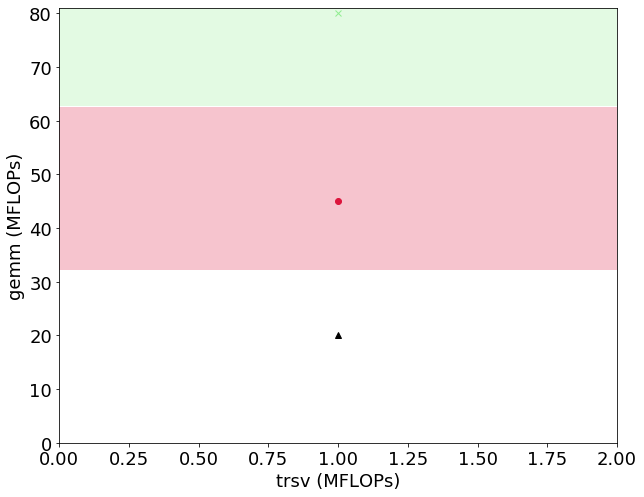

In [391]:
kernelA = 'trsv'
kernelB = 'gemm'
fig = da.get_regions_plot(kernelA, kernelB)

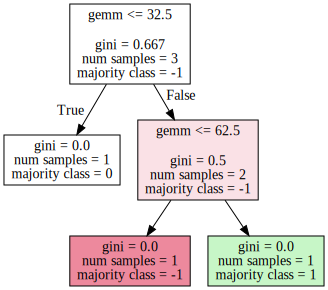

In [392]:
dtree = da.get_dtree(kernelA, kernelB)
dtree

In [393]:
ops = da.find_operands_on_cl(kernelA, kernelB, -1)
ops

['1000_150']

In [194]:
ops = da.find_operands_on_flops(kernelA, kernelB, ">", 50.0, "<", 0.5 )
ops

['1000_200', '1000_100', '1000_150']

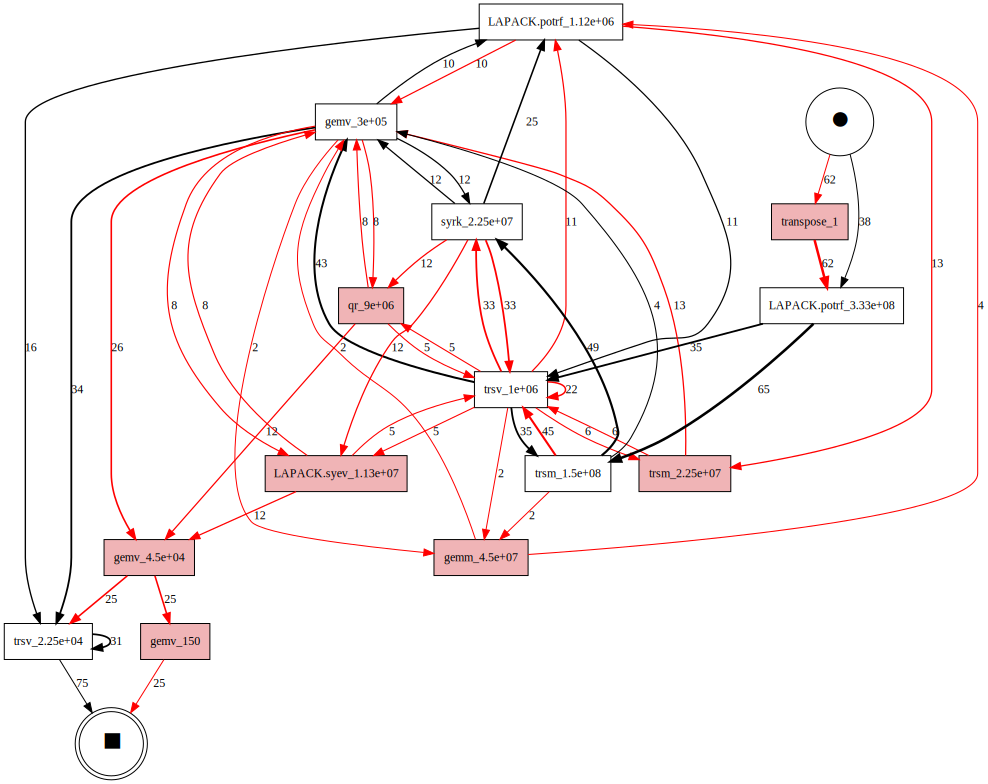

In [394]:
de.data_vcs[ops[0]].get_dfg_minus_best_worst()

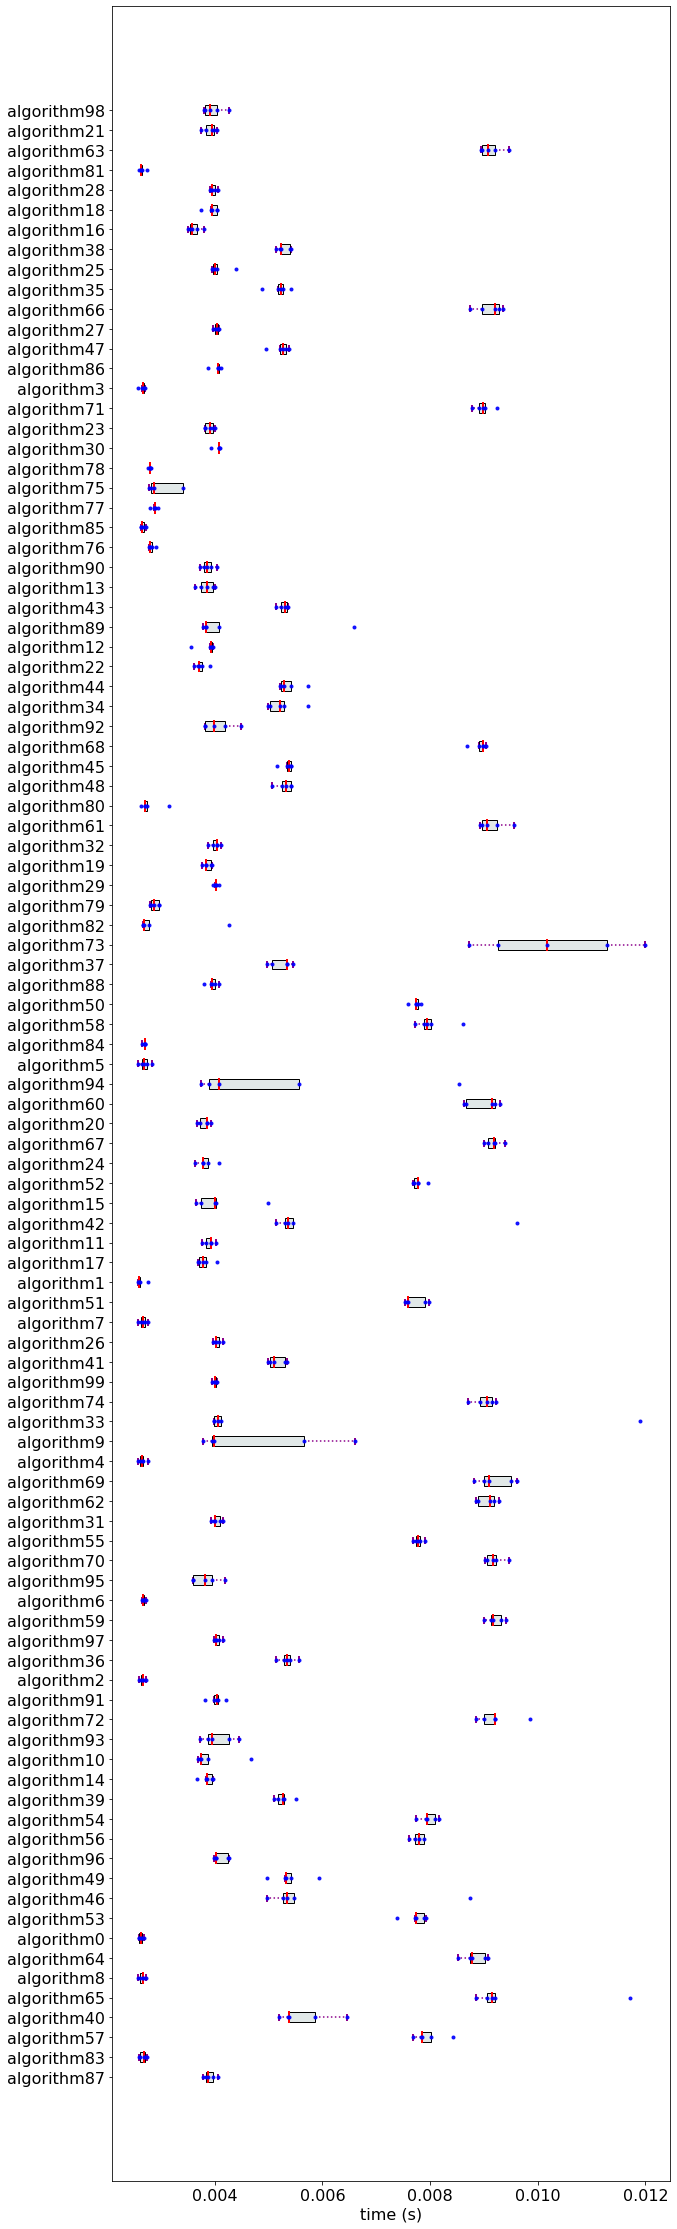

In [398]:
#get als of class 0 vs algs having that specific relation
fig = de.visualize_box_plots(ops[0], scale=0.4)

In [396]:
de.data_ranks[ops[0]]

,case:concept:name,case:rank:q75-q25
0,algorithm0,0
1,algorithm4,0
2,algorithm1,0
3,algorithm83,1
4,algorithm8,1
...,...,...
95,algorithm59,18
96,algorithm70,18
97,algorithm69,18
98,algorithm67,18


In [60]:
da.filter_relations_on_selection_scores(val1=1.0,val2=0.0)

class,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,1,@@startnode,transpose,1,0,0,1,0.0,1.0,0.0
1,2,LAPACK.potrf,gemv,1,4,0,5,0.0,0.2,0.0
5,12,transpose,LAPACK.potrf,1,0,0,1,0.0,1.0,0.0
2,5,gemv,LAPACK.potrf,0,4,1,5,0.2,0.0,1.0
3,9,syrk,LAPACK.potrf,0,4,1,5,0.2,0.0,1.0
4,10,syrk,gemv,0,4,1,5,0.2,0.0,1.0
6,18,trsv,gemv,0,3,2,5,0.4,0.0,1.0
7,20,trsv,trsm,0,4,1,5,0.2,0.0,1.0


In [157]:
da.get_relation_data(kernelA, kernelB)

,trsm,gemv,class
11,200.0,0.4,1
32,300.0,0.6,-1
53,100.0,0.2,1
74,150.0,0.3,1
97,10.0,0.2,0


In [61]:
da.filter_relations_on_selection_scores(val1=-1.0)

class,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,0,@@startnode,LAPACK.potrf,0,5,0,5,0.0,0.0,-1.0
1,3,LAPACK.potrf,trsm,0,5,0,5,0.0,0.0,-1.0
2,7,gemv,trsm,0,1,0,1,0.0,0.0,-1.0
3,8,gemv,trsv,0,5,0,5,0.0,0.0,-1.0
4,14,trsm,syrk,0,5,0,5,0.0,0.0,-1.0
5,16,trsv,@@endnode,0,5,0,5,0.0,0.0,-1.0
6,21,trsv,trsv,0,6,0,6,0.0,0.0,-1.0


In [62]:
da.get_relation_data('trsm', 'trsv')

/var/folders/sv/jmmtzklx49g03qzbkrpz_cdr0000gp/T/ipykernel_24652/623176249.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['flopsA'] = x['flopsA']*10**-6
/var/folders/sv/jmmtzklx49g03qzbkrpz_cdr0000gp/T/ipykernel_24652/623176249.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['flopsB'] = x['flopsB']*10**-6


,trsm,trsv,class
13,200.0,1.00,1
34,300.0,1.00,0
55,100.0,1.00,0
76,150.0,1.00,-1
99,10.0,0.01,0
